In [3]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

In [4]:
edges = pd.read_csv('../../data/Flickr_sampled_edges/edges_sampled_2K.csv')
edges = edges.rename(columns = {edges.columns[0]: 'from', edges.columns[1]:'to'})
edges['weight'] = 1

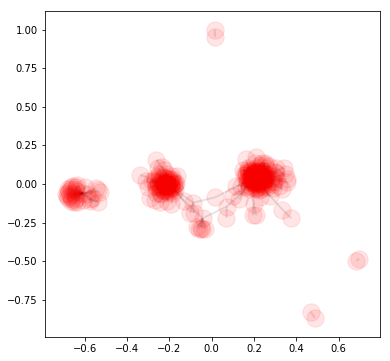

In [5]:
G = nx.from_pandas_edgelist(edges, 'from', 'to', 'weight')
rcParams['figure.figsize'] = 6, 6
nx.draw_networkx(G, with_labels=False, alpha=0.1, width=2)

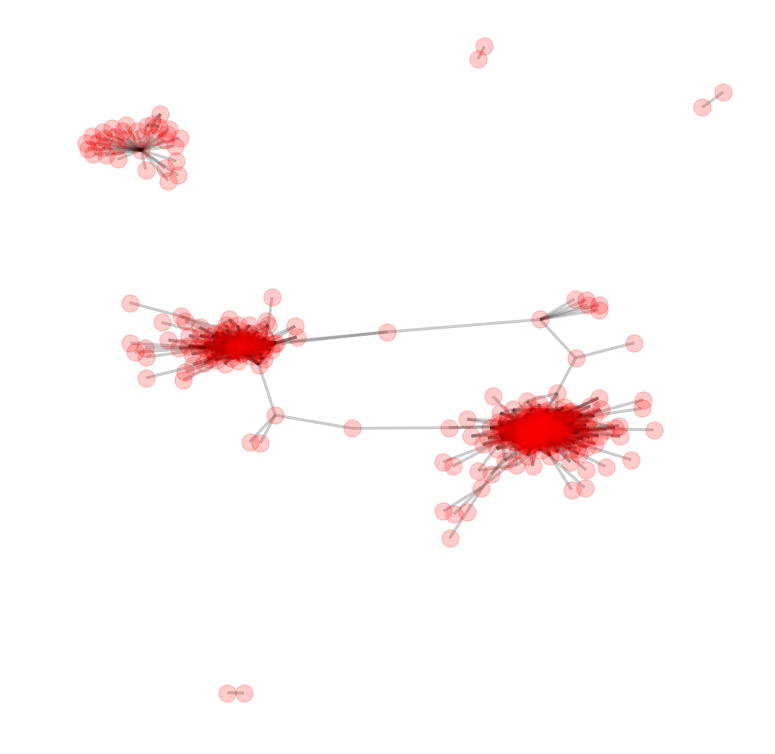

algo run in 234.126910  seconds


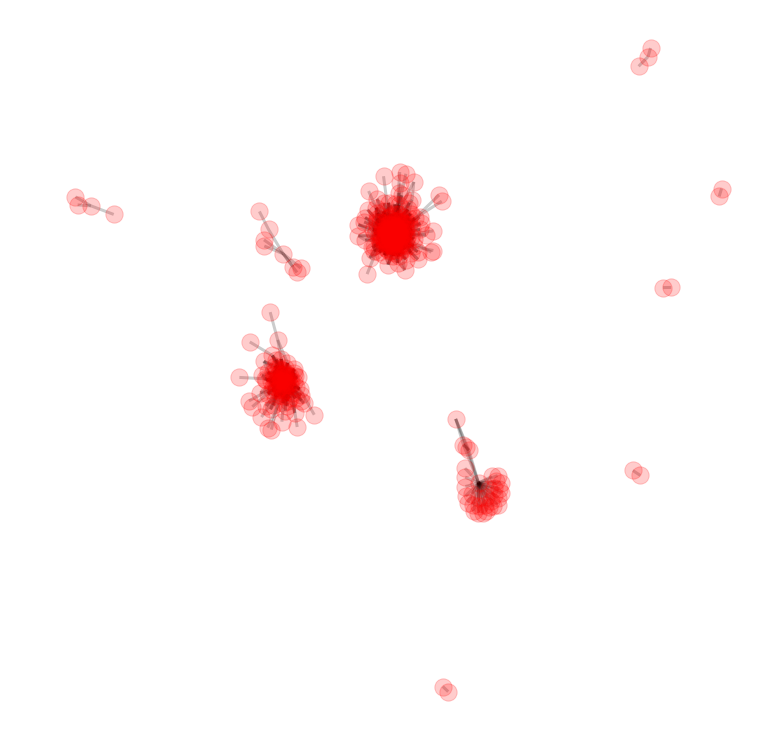

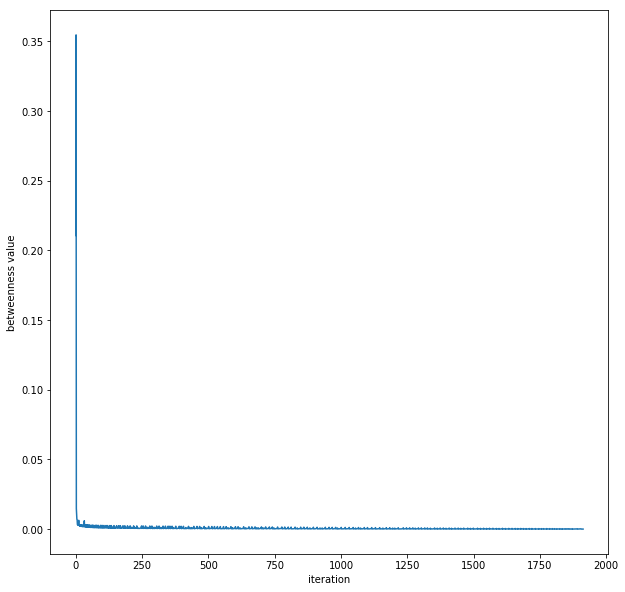

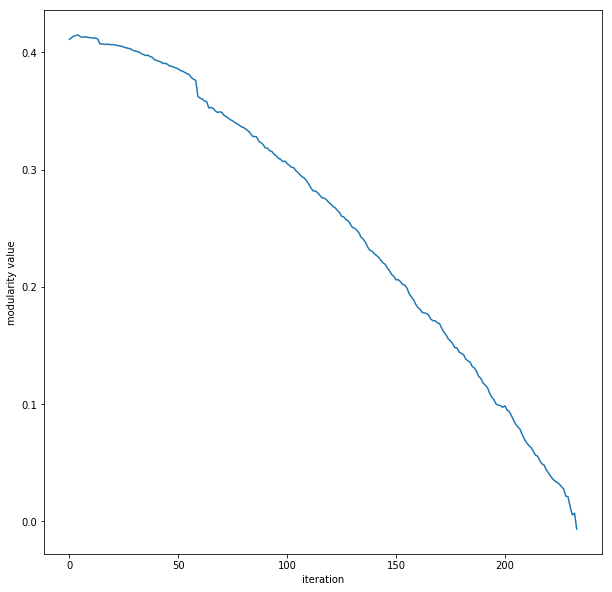

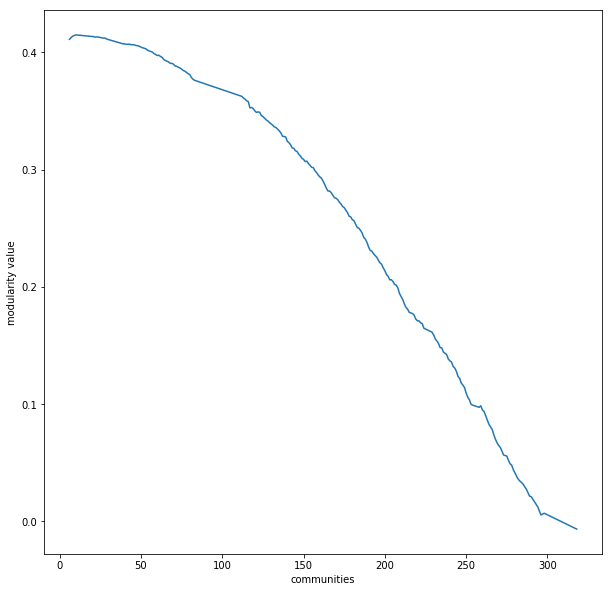

In [31]:

import networkx as nx
import math
import csv
import random as rand
import sys
import time
import matplotlib.pyplot as plt

_DEBUG_ = False
# command to run 
# python cmty.py graph.txt -g -d -b -m -c -s 10
# -g means draw graph after built
# -d means debug mode
# -b means plot betweenes values
# -m means plot modularity values
# -c means draw community structure
# for large graphs modularity value might overflow

#this method just reads the graph structure from the file
def buildG(G, file_, delimiter_):
    #construct the weighted version of the contact graph from cgraph.dat file
    #reader = csv.reader(open("/home/kazem/Data/UCI/karate.txt"), delimiter=" ")
    reader = csv.reader(open(file_), delimiter=delimiter_)
    for line in reader:
        if len(line) > 2:
            if float(line[2]) != 0.0:
                #line format: u,v,w
                G.add_edge(int(line[0]),int(line[1]),weight=float(line[2]))
        else:
            #line format: u,v
            G.add_edge(int(line[0]),int(line[1]),weight=1.0)

#keep removing edges from Graph until one of the connected components of Graph splits into two
#compute the edge betweenness
def CmtyGirvanNewmanStep(G, bwt_values):
    global _DEBUG_
    if _DEBUG_:
        print ("Calling CmtyGirvanNewmanStep")
    init_ncomp = nx.number_connected_components(G)    #no of components
    ncomp = init_ncomp
    while ncomp <= init_ncomp:
        bw = nx.edge_betweenness_centrality(G)    #edge betweenness for G
        #find the edge with max centrality
        if len(bw.values()) == 0:
                break
        max_ = max(bw.values())
        bwt_values.append(max_)
        #find the edge with the highest centrality and remove all of them if there is more than one!
        for k, v in bw.items():
                if float(v) == max_:
                        G.remove_edge(k[0],k[1])    #remove the central edge
        ncomp = nx.number_connected_components(G)    #recalculate the no of components

#compute the modularity of current split
def _GirvanNewmanGetModularity(G, deg_, m_, number_of_communities):
    global _DEBUG_
    New_A = nx.adj_matrix(G)
    New_deg = {}
    New_deg = UpdateDeg(New_A, G.nodes())
    #Let's compute the Q
    comps = nx.connected_components(G)    #list of components    
    # print 'No of communities in decomposed G: %d' % nx.number_connected_components(G)
    Mod = 0    #Modularity of a given partitionning
    for c in comps:
        EWC = 0    #no of edges within a community
        RE = 0    #no of random edges
        for u in c:
            EWC += New_deg[u]
            RE += deg_[u]        #count the probability of a random edge
        Mod += ( float(EWC) - float(RE*RE)/float(2*m_) )
    Mod = Mod/float(2*m_)
    if _DEBUG_:
        print ("Modularity: %f" % Mod)
    return Mod

def UpdateDeg(A, nodes):
    deg_dict = {}
    n = len(nodes)  #len(A)
    B = A.sum(axis = 1)
    for i in range(n):
        deg_dict[list(nodes)[i]] = B[i, 0]
    return deg_dict

#run GirvanNewman algorithm and find the best community split by maximizing modularity measure
def runGirvanNewman(G, Orig_deg, m_, modularities, bwt_values, cut_off, number_of_communities):
    #let's find the best split of the graph
    BestQ = 0.0
    Q = 0.0
    Bestcomps_t = []
    best_graph = nx.Graph()
    prev_mod = 0
    curr_mod = None
    successive_decrease_count = 0

    while True:    
        CmtyGirvanNewmanStep(G, bwt_values)
        Q = _GirvanNewmanGetModularity(G, Orig_deg, m_, number_of_communities);
        curr_mod = Q
        if prev_mod > curr_mod:
            successive_decrease_count = successive_decrease_count + 1
        if cut_off != None and successive_decrease_count > cut_off:
            break
        modularities.append(Q)
        number_of_communities.append(nx.number_connected_components(G))


        #print "Modularity of decomposed G: %f" % Q
        if Q > BestQ:
                BestQ = Q
                #Bestcomps = nx.connected_components(G)    #Best Split
                best_graph = G.copy()
        if G.number_of_edges() == 0:
                break
        prev_mod = curr_mod
    return best_graph


global _DEBUG_


graph_fn = True
cut_off = None
DEBUG_ = True
draw_graph = True
plot_betweenness = True
plot_modularity = True
draw_community = True
plot_mod_com = True
has_cut_off = True
cut_off = 1000

edges = pd.read_csv('../../data/Flickr_sampled_edges/edges_sampled_2K.csv')
edges = edges.rename(columns = {edges.columns[0]: 'from', edges.columns[1]:'to'})
edges['weight'] = 1

G = nx.from_pandas_edgelist(edges, 'from', 'to', 'weight')
rcParams['figure.figsize'] = 10, 10
#nx.draw_networkx(G, with_labels=False, alpha=0.1, width=2)
start = time.time()

if _DEBUG_:
    print ('G nodes:', G.nodes())
    print ('G no of nodes:', G.number_of_nodes())

if draw_graph:
    nx.draw(G, alpha = 0.2, width = 3)
    plt.show()

n = G.number_of_nodes()    #|V|
A = nx.adj_matrix(G)    #adjacenct matrix

m_ = 0.0    #the weighted version for number of edges
for i in range(0,n):
    for j in range(0,n):
        m_ += A[i,j]
m_ = m_/2.0
if _DEBUG_:
    print ("m: %f" % m_)

#calculate the weighted degree for each node
Orig_deg = {}
Orig_deg = UpdateDeg(A, G.nodes())

modularities = []
bwt_values = []
number_of_communities = []
#run Newman alg
start = time.time()
best_graph = runGirvanNewman(G, Orig_deg, m_, modularities, bwt_values, cut_off, number_of_communities)
end = time.time()
print ('algo run in %f' % (end - start), ' seconds')


if draw_community:
    nx.draw(best_graph, alpha = 0.2, width = 3)
    plt.show()

if plot_betweenness:
    plt.plot(bwt_values)
    plt.ylabel('betweenness value')
    plt.xlabel('iteration')
    plt.show()

if plot_modularity:
    plt.plot(modularities)
    plt.ylabel('modularity value')
    plt.xlabel('iteration')
    plt.show()
    
if plot_mod_com:
    plt.plot(number_of_communities, modularities)
    plt.ylabel('modularity value')
    plt.xlabel('communities')
    plt.show()

In [7]:
bwt_values

[0.2107867359088901,
 0.35468126897208496,
 0.014761026129397059,
 0.01035652639723826,
 0.007063071642560958,
 0.00682499057595778,
 0.003392655199095292,
 0.002960402280120644,
 0.0034521754657460863,
 0.0029477157013098124,
 0.0036245683614603095,
 0.006309148264984227,
 0.0026449235994456498,
 0.0031347340436085154,
 0.00233500085255892,
 0.0031148939547249173,
 0.00216688448601546,
 0.0030950538658413187,
 0.0021331278597951767,
 0.0030752137769577206,
 0.0019763458517789282,
 0.0030553736880741225,
 0.0019608114914269645,
 0.0019318744279777493,
 0.002551054811798915,
 0.0030355335991905244,
 0.0017611016834597425,
 0.001706247643989445,
 0.001699372753112381,
 0.0021435999789520487,
 0.0025074253462490374,
 0.0031838991939763727,
 0.005991706842846656,
 0.001664075805464413,
 0.0021335893822317536,
 0.0029760133325397297,
 0.0016522083976612115,
 0.0029561732436561316,
 0.0016207040606294682,
 0.0029363331547725335,
 0.0015655211452662904,
 0.001837118878241117,
 0.0029164930658

algo run in 3.300669  seconds


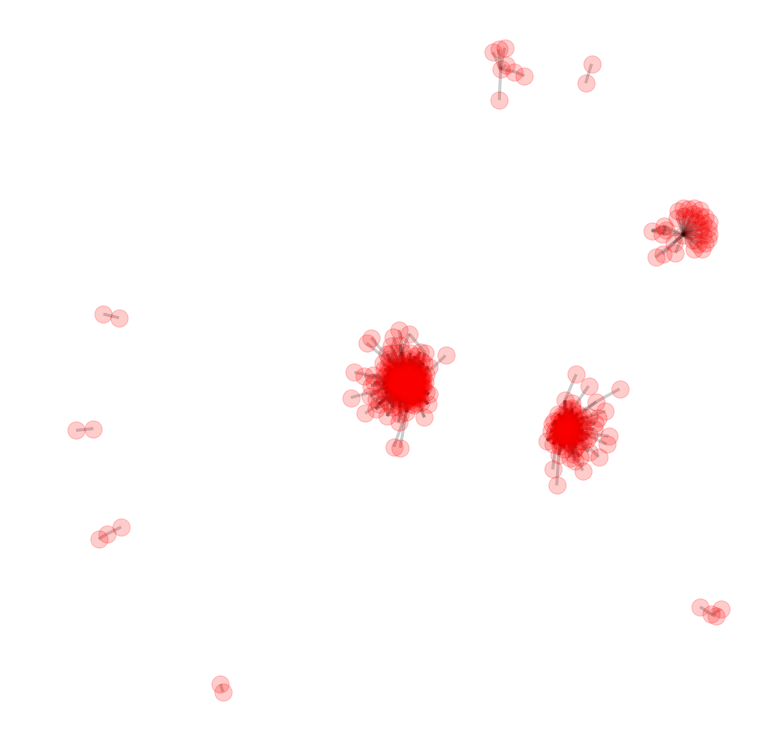

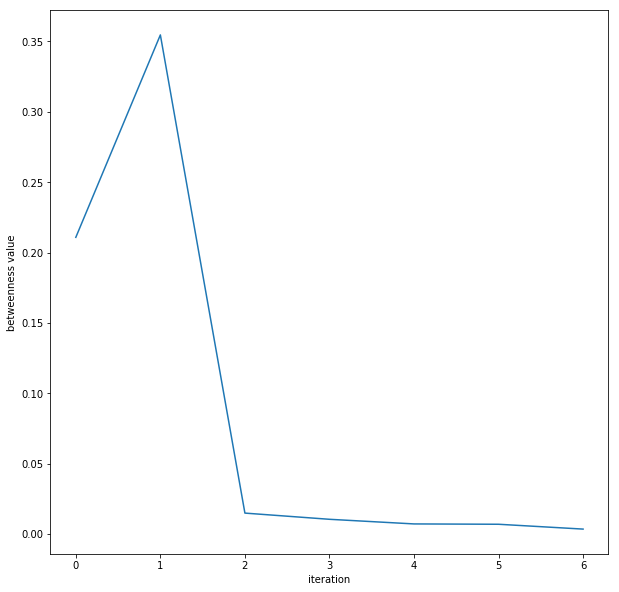

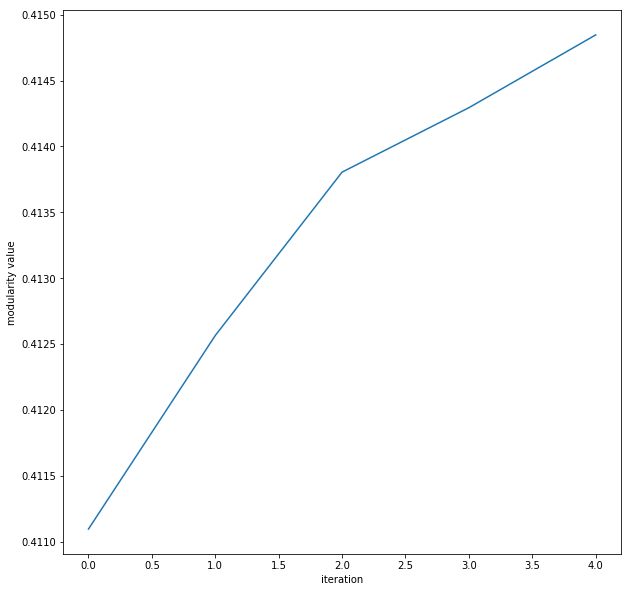

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

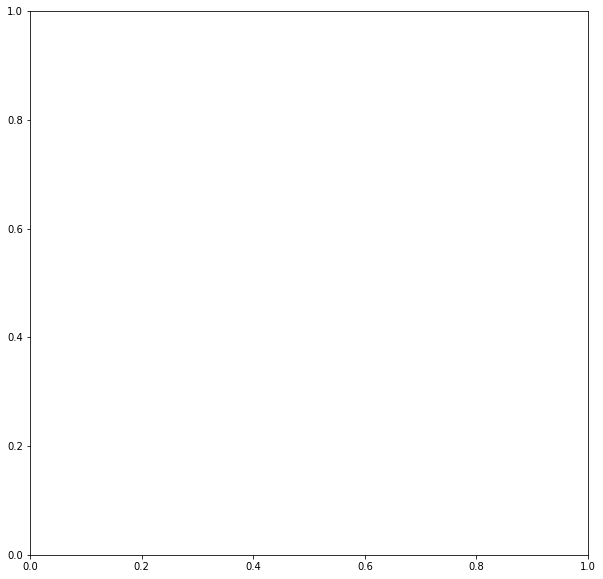

In [19]:
graph_fn = True
cut_off = None
DEBUG_ = True
draw_graph = False
plot_betweenness = True
plot_modularity = True
draw_community = True
has_cut_off = True
cut_off = 10
community = []

edges = pd.read_csv('../../data/Flickr_sampled_edges/edges_sampled_2K.csv')
edges = edges.rename(columns = {edges.columns[0]: 'from', edges.columns[1]:'to'})
edges['weight'] = 1

for cut_off in range(20):

    G = nx.from_pandas_edgelist(edges, 'from', 'to', 'weight')
    rcParams['figure.figsize'] = 10, 10
    #nx.draw_networkx(G, with_labels=False, alpha=0.1, width=2)
    start = time.time()

    if _DEBUG_:
        print ('G nodes:', G.nodes())
        print ('G no of nodes:', G.number_of_nodes())

    if draw_graph:
        nx.draw(G, alpha = 0.2, width = 3)
        plt.show()

    n = G.number_of_nodes()    #|V|
    A = nx.adj_matrix(G)    #adjacenct matrix

    m_ = 0.0    #the weighted version for number of edges
    for i in range(0,n):
        for j in range(0,n):
            m_ += A[i,j]
    m_ = m_/2.0
    if _DEBUG_:
        print ("m: %f" % m_)

    #calculate the weighted degree for each node
    Orig_deg = {}
    Orig_deg = UpdateDeg(A, G.nodes())

    modularities = []
    bwt_values = []
    #run Newman alg
    start = time.time()
    best_graph = runGirvanNewman(G, Orig_deg, m_, modularities, bwt_values, cut_off, number_of_communities)
    end = time.time()
    print ('algo run in %f' % (end - start), ' seconds')
    
    if draw_community:
        nx.draw(best_graph, alpha = 0.2, width = 3)
        plt.show()

    if plot_betweenness:
        plt.plot(bwt_values)
        plt.ylabel('betweenness value')
        plt.xlabel('iteration')
        plt.show()

    if plot_modularity:
        plt.plot(modularities)
        plt.ylabel('modularity value')
        plt.xlabel('iteration')
        plt.show()
        
    if plot_mod_com:
        plt.plot(number_of_communities[1:], modularities)
        plt.ylabel('modularity value')
        plt.xlabel('communities')
        plt.show()